In [2]:
from line_profiler import LineProfiler

In [3]:
from dataclasses import dataclass
from typing import List, Tuple, Optional
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.stats as st
from statistics import NormalDist
from scipy.stats import multivariate_normal as mvn
import time
from scipy import stats
import multiprocessing as mp
import dataclasses

@dataclass
class NormalDistribution:
    mean: float
    std: float
    
@dataclass
class Part:
    
    type: str
    sub_part_name: str
    sensor: str
    signals: List   # Signal is numpy array of (500,3) with [frequency, Z, X]

In [17]:
print(os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), 'data', 'x')))

/Users/michael/GradSchool/Fall2022/piezo_research/matcher/psig_matcher/data/x


In [46]:

def load_part_data(part_type: str) -> List[Part]:
    
    parts = []
    fpath = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), 'data'))
    print(fpath)  # handle general paths
    # f'psig_matcher/data/{part_type}'
    for part_dir in os.listdir(os.path.join(fpath, part_type)):
        sensor = part_dir[1:]
        print(os.path.join(fpath, part_dir, part_type))
        measurement_files = glob.glob(f'{os.path.join(fpath, part_type, part_dir)}/*.npy')
        measurements = [np.load(f) for f in measurement_files]
        parts.append(Part(part_type, part_dir, sensor, measurements))
    
    return parts

con_parts = load_part_data('CON')
#conlid_parts = load_part_data('CONLID') # Need to handle the damage files
lid_parts = load_part_data('LID')

/Users/michael/GradSchool/Fall2022/piezo_research/matcher/psig_matcher/data
/Users/michael/GradSchool/Fall2022/piezo_research/matcher/psig_matcher/data/Ax1/CON
/Users/michael/GradSchool/Fall2022/piezo_research/matcher/psig_matcher/data/Cx3/CON
/Users/michael/GradSchool/Fall2022/piezo_research/matcher/psig_matcher/data/Bx2/CON
/Users/michael/GradSchool/Fall2022/piezo_research/matcher/psig_matcher/data
/Users/michael/GradSchool/Fall2022/piezo_research/matcher/psig_matcher/data/Bx5/LID
/Users/michael/GradSchool/Fall2022/piezo_research/matcher/psig_matcher/data/Cx6/LID
/Users/michael/GradSchool/Fall2022/piezo_research/matcher/psig_matcher/data/Ax4/LID


In [47]:
def limit_deminsionality(parts: List[Part], frequeny_indexes: List[int]) -> List[Part]:
    """Use only a subset of the frequencies for the analysis. This effectivley transforms the 
    500 dimension multivariant distribution to a n-dimentional distribution where n is the
    length of the frequency_indexes.
    
    Further, this assumes use of the X axis"""
    
    return [
        dataclasses.replace(part, signals=[[signal[index][1] for index in frequeny_indexes] for signal in part.signals])
        for part in parts]

In [21]:
def estimate_normal_dist(x: List[float], confidence: float) -> NormalDistribution:
    """Estimate the normal distribution for the given data.
    This is done using: https://handbook-5-1.cochrane.org/chapter_7/7_7_3_2_obtaining_standard_deviations_from_standard_errors_and.htm#:~:text=The%20standard%20deviation%20for%20each,should%20be%20replaced%20by%205.15.
    
    TODO (henry): I'm not sure this is correct.
    """
    
    # Use T distribution for small sample sizes
    if len(x) < 30:
        lower, upper = st.t.interval(confidence, len(x)-1, loc=np.mean(x), scale=st.sem(x))
        t_value = st.t.ppf(confidence, len(x)-1)
        std = np.sqrt(len(x))*(upper-lower)*t_value
    
    # Use normal distribution for larger sample sizes
    else:
        lower, upper = st.norm.interval(confidence, loc=np.mean(x), scale=st.sem(x))
        z_value = st.norm.ppf(confidence)
        std = np.sqrt(len(x))*(upper-lower)*z_value
    
    return NormalDistribution(np.mean(x, axis=0), std)

In [48]:
def concrete_normal_dist(x: List[float]) -> NormalDistribution:
    return NormalDistribution(np.mean(x, axis=0), np.std(x, axis=0))

In [49]:
def plot_single_distributions(pdfs: List[NormalDistribution], labels: List[str], title: str):
    """ pdfs is a list of tuples of (mean, std) for each distribution."""
    
    for pdf, label in zip(pdfs, labels):
        
        x = np.linspace(pdf.mean - 3* pdf.std, pdf.mean + 3* pdf.std, 100)
        plt.plot(x, norm.pdf(x, pdf.mean, pdf.std), label=label)
    
    plt.legend(loc='best')
    plt.title(title)
    plt.show()

In [50]:
def find_overlap(normal_d_1: NormalDistribution, normal_d_2: NormalDistribution) -> float:
    """Finds the overlap between two distributions."""
    
    return NormalDist(mu=normal_d_1.mean, sigma=normal_d_1.std).overlap(NormalDist(mu=normal_d_2.mean, sigma=normal_d_2.std))


In [51]:
def find_overlap_of_set(pdfs: List[NormalDistribution]) -> float:
    """Finds the overlap between a set of distributions."""
    
    overlaps = []
    for i in range(len(pdfs)):
        for k in range(i+1, len(pdfs)):
            # Currently this method redundantly counts overlaps that may have already been accounted for. 
            # If A and B overlap on the edge of B, but C also overlaps on the edge of B, we're double
            # counting that overlap. Maybe we want to do this? 
            overlaps.append(find_overlap(pdfs[i], pdfs[k]))
    
    return np.mean(overlaps)

[Part(type='CON', sub_part_name='Ax1', sensor='x1', signals=[array([[ 1.000000e+04,  1.241903e+03, -1.236173e+03],
       [ 1.028100e+04,  1.205009e+03, -1.200160e+03],
       [ 1.056100e+04,  1.169480e+03, -1.164446e+03],
       ...,
       [ 1.494400e+05,  1.367002e+02, -1.322233e+02],
       [ 1.497200e+05,  1.352763e+02, -1.310638e+02],
       [ 1.500000e+05,  1.339089e+02, -1.298953e+02]]), array([[ 1.000000e+04,  1.237804e+03, -1.232429e+03],
       [ 1.028100e+04,  1.197501e+03, -1.192977e+03],
       [ 1.056100e+04,  1.161383e+03, -1.156226e+03],
       ...,
       [ 1.494400e+05,  1.365823e+02, -1.320626e+02],
       [ 1.497200e+05,  1.351697e+02, -1.309199e+02],
       [ 1.500000e+05,  1.338186e+02, -1.297711e+02]]), array([[ 1.000000e+04,  1.231336e+03, -1.224784e+03],
       [ 1.028100e+04,  1.194632e+03, -1.188328e+03],
       [ 1.056100e+04,  1.174042e+03, -1.167742e+03],
       ...,
       [ 1.494400e+05,  1.353826e+02, -1.316107e+02],
       [ 1.497200e+05,  1.339316e+0

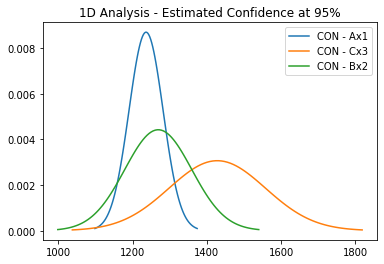

Overlap of Estimated pdf's at 95% confidence: 0.44525124412818345


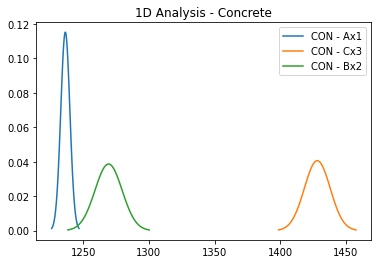

Overlap of concrete pdf's: 0.004909880876262762


In [52]:
def perform_1d_analysis(parts: List[Part]):
    
    single_d_parts = limit_deminsionality(parts, [0])
    print(single_d_parts[0].signals)
    pdfs = [estimate_normal_dist(part.signals, 0.95) for part in single_d_parts]
    plot_single_distributions(pdfs, [f"{part.type} - {part.sub_part_name}" for part in single_d_parts], f'1D Analysis - Estimated Confidence at 95%')
    print(f"Overlap of Estimated pdf's at 95% confidence: {find_overlap_of_set(pdfs)}")
    
    pdfs = [concrete_normal_dist(part.signals) for part in single_d_parts]
    plot_single_distributions(pdfs, [f"{part.type} - {part.sub_part_name}" for part in single_d_parts], f'1D Analysis - Concrete')
    print(f"Overlap of concrete pdf's: {find_overlap_of_set(pdfs)}")
    
    
    
print(con_parts)
perform_1d_analysis(con_parts)
#perform_1d_analysis(lid_parts)


In [34]:
def estimate_overlap_of_set_with_meta_pdf(pdfs: List[NormalDistribution], samples: int, confidence_bound: float) -> float:
    """Estimates the overlap between a set of distributions.
    
    The meta pdf is really just the combined pdfs of all the distributions, then we're drawing from that
    and seeing how many samples would cause conflicts. How can we prove the distribution we're pulling samples
    from is representative of the entire population? Is the estimated confidence good enough? 
    
    Could we potentially randomly sample from each distribution and just see which ones end up overlapping
    with the other distributions? TODO (henry): Think about this more 
    
    TODO (henry): This takes so long, like 5's per sample. We need to run 10,000's samples many times. 
    Need to computationall optimize this.
    """
    
    pdf_means = [pdf.mean for pdf in pdfs]    
    min_confidence = 1 - confidence_bound
    meta_pdf = estimate_normal_dist(pdf_means, 0.95)
    print(f"meta_pdf mean {meta_pdf.mean}")  # this is a nan and is causing an error when called from estimate_overlap_of_set_with_meta_pdf
    meta_samples = np.random.multivariate_normal(meta_pdf.mean, np.diag(meta_pdf.std), samples)
    mvn_pdfs = [mvn(mean=pdf.mean, cov=pdf.std) for pdf in pdfs]
        
    sample_confidences = [
        [pdf.cdf(sample) for pdf in mvn_pdfs]
        for sample in meta_samples]
    
    filtered_confidences = [
        list(filter(lambda confidence: confidence >= min_confidence, sample_confidence))
        for sample_confidence in sample_confidences]

    # We're ok with up to 1 match, but every one more than that is a conflict.
    collisions = [max(len(confidences)-1, 0) for confidences in filtered_confidences]
    return sum(collisions)/(samples*len(pdfs))
    

In [30]:
def estimate_overlap_of_set_with_individual_pdf(pdfs: List[NormalDistribution], samples: int, confidence_bound: float) -> float:
    """Estimates the overlap between a set of distributions.
    
    Pull from the samples from each individual distribution and see how many samples would cause conflicts 
    with other distributions. 
    
    Does this really represent the range of the entire population?
    
    TODO (henry): This takes so long, like 5's per sample per pdf. We need to run 10,000's samples many times. 
    Need to computationall optimize this.
    """
    
    min_confidence = 1 - confidence_bound
    mvn_pdfs = [mvn(mean=pdf.mean, cov=pdf.std) for pdf in pdfs]
    pdf_samples = [
        np.random.multivariate_normal(pdf.mean, np.diag(pdf.std), samples) 
        for pdf in pdfs]
    
    # flatten the samples
    pdf_samples = [sample for pdf_sample in pdf_samples for sample in pdf_sample]
    sample_confidences = [
        [pdf.cdf(sample) for pdf in mvn_pdfs]
        for sample in pdf_samples]
    
    filtered_confidences = [
        list(filter(lambda confidence: confidence >= min_confidence, sample_confidence))
        for sample_confidence in sample_confidences]
    
    # We're ok with up to 1 match, but every one more than that is a conflict.
    collisions = [max(len(confidences)-1, 0) for confidences in filtered_confidences]
    return sum(collisions)/(samples*len(pdfs))

In [31]:
def probability_of_multivariant_point(mu: List[float], cov: List[List[float]], x: List[float]) -> float:
    
    #https://stats.stackexchange.com/questions/331283/how-to-calculate-the-probability-of-a-data-point-belonging-to-a-multivariate-nor
    # Double check this math
    m_dist_x = np.dot((x-mu).transpose(),np.linalg.inv(cov))
    m_dist_x = np.dot(m_dist_x, (x-mu))
    return 1-stats.chi2.cdf(m_dist_x, 3)

In [32]:
def estimate_overlap_of_set_with_sample_signals(parts: List[Part], samples: int, meta_pdf_ci: float, part_pdf_ci: float, confidence_bound: float) -> float:
    """ I believe this is the best solution out of all them. We are directly modeling the distribution/state space that
    the signals come from, and sampling from that. This directly correlates with the CI and is intuitive. See notion for
    more details and defense. """
    
    min_confidence = 1 - confidence_bound
    signals = [
        signal for part in parts 
        for signal in part.signals]
    
    part_pdfs = [estimate_normal_dist(part.signals, part_pdf_ci) for part in parts]
    sample_pdf = estimate_normal_dist(signals, meta_pdf_ci)
    
    state_space_samples = np.random.multivariate_normal(sample_pdf.mean, np.diag(sample_pdf.std), samples)
    
    # using probability_of_multivariant_point no longer directly equates to false negative rate.
    # TODO (henry): Figure out relationship between integrated pdf range and false negative rate
    sample_confidences = [
        [probability_of_multivariant_point(pdf.mean, np.diag(pdf.std), sample) for pdf in part_pdfs]
        for sample in state_space_samples]

    filtered_confidences = [
        list(filter(lambda confidence: confidence >= min_confidence, sample_confidence))
        for sample_confidence in sample_confidences]

    # We're ok with up to 1 match, but every one more than that is a conflict.
    collisions = [max(len(confidences)-1, 0) for confidences in filtered_confidences]
    return sum(collisions)/(samples*len(part_pdfs))

In [35]:

def perform_multivariant_analsis(parts: List[Part]):
    
    # TOOD (henry): Abstract this out to run many times and plot CI until convergence.
    
    multivariant_parts = limit_deminsionality(parts, list(range(1)))
    pdfs = [estimate_normal_dist(part.signals, 0.95) for part in multivariant_parts]
    
    estimated_meta_collision_rate = estimate_overlap_of_set_with_meta_pdf(pdfs, 10, 0.95)
    print(f"Estimated collision rate from meta pdf: {estimated_meta_collision_rate}")
    
    estimated_set_collision_rate = estimate_overlap_of_set_with_individual_pdf(pdfs, 10, 0.95)
    print(f"Estimated collision rate from set of individual pdfs: {estimated_set_collision_rate}")
    
    estimated_sample_collision_rate = estimate_overlap_of_set_with_sample_signals(multivariant_parts, 10, 0.95)
    print(f"Estimated collision rate from sample distributiion: {estimated_sample_collision_rate}")

perform_multivariant_analsis(con_parts)

meta_pdf mean nan


/Users/michael/envs/bsb/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/michael/envs/bsb/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/michael/envs/bsb/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/michael/envs/bsb/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/michael/envs/bsb/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: Input must be 1- or 2-d.

In [36]:
def compute_normal_ci(x: List[float], confidence: float) -> Tuple[float, float]:
    """Computes the confidence interval for a given confidence bound."""
    
    if sum(x) == 0: return (0, 0)
    return stats.norm.interval(confidence, loc=np.mean(x), scale=np.std(x))

In [37]:
def run_meta_markov_multivariant_analysis(parts: List[Part], part_dimensionality: int, samples: int, meta_pdf_ci: float, part_pdf_ci: float, confidence_bound: float):
    """ Runs the Monte Carlo Approximation of multivariant collision using the signal sample meta
    pdf methodoly. The Monte Carlo Approximation will continually be run until the confidence interval
    converges and the average of the previous 10 runs is not smaller than the average of the previous 100 runs."""
    
    collisions = []
    confidence_ranges = []
    while True:
        
        multivariant_parts = limit_deminsionality(parts, list(range(part_dimensionality)))
        collision_rate = estimate_overlap_of_set_with_sample_signals(multivariant_parts, samples, meta_pdf_ci, part_pdf_ci, confidence_bound)
        
        collisions.append(collision_rate)
        lower, upper = compute_normal_ci(collisions, 0.95)
        confidence_ranges.append(upper - lower)
        print(f"Estimated collision rate from sample distributiion has range: {upper - lower}")
        
        if len(confidence_ranges) > 100 and np.mean(confidence_ranges[-10:]) >= np.mean(confidence_ranges[-100:]):
            return upper
    

upper_collision_rate = run_meta_markov_multivariant_analysis(con_parts, 5, 100, 0.99, 0.99, 0.99)
print(f"Upper collision rate: {upper_collision_rate * 100}%")


ValueError: Input must be 1- or 2-d.